# Build a Customer Support Router Agentic RAG System

In this project, we will leverage the power of AI Agents and RAG Systems to build an intelligent Router Agentic RAG System to handle customer support queries using a custom knowledgebase.

![](https://i.imgur.com/bLCdxCI.png)

### Intelligent Router Agentic RAG System

This project focuses on building an **Intelligent Router Agentic RAG System** that combines intelligent query analysis, sentiment detection, and dynamic routing with Retrieval-Augmented Generation (RAG) to handle diverse user inquiries efficiently. The workflow includes the following components:

1. **Query Categorization and Sentiment Analysis**:
   - The system uses **OpenAI GPT-4o** to analyze the user's query and determine:
     - **Query Category**: Identifies the type of problem, such as billing, technical issues, or general queries.
     - **User Sentiment**: Evaluates the user's sentiment (positive, neutral, or negative) to determine if escalation is needed.

2. **Intelligent Routing**:
   - Based on the **query_category** and **query_sentiment**, the system routes the query to the appropriate handling node:
     - **Escalate to Human**: If the sentiment is negative, the query is escalated to a human for resolution.
     - **Generate Billing Response**: Queries related to billing are routed to generate an appropriate response.
     - **Generate Technical Response**: Technical queries are routed for a specialized technical response.
     - **Generate General Response**: General queries are handled with context-aware responses.

3. **Knowledge Base Integration (RAG)**:
   - The system integrates with a **Knowledge Base (Vector Database)** to augment responses with relevant and accurate information.
   - Retrieval-Augmented Generation (RAG) ensures that responses are grounded in the latest and most reliable data.

4. **Escalation Mechanism**:
   - Negative sentiment triggers an **escalation to a human**, ensuring the user receives empathetic and personalized support for critical issues.


## Install OpenAI, LangGraph and LangChain dependencies

In [ ]:
!pip install langchain==0.3.14
!pip install langchain-openai==0.3.0
!pip install langchain-community==0.3.14
!pip install langgraph==0.2.64

In [ ]:
!pip install langchain-chroma==0.2.0

## Enter Open AI API Key

In [ ]:
from getpass import getpass

OPENAI_KEY = getpass('Enter Open AI API Key: ')

## Setup Environment Variables

In [ ]:
import os

os.environ['OPENAI_API_KEY'] = OPENAI_KEY

## Load Company Knowledge Base

In [3]:
# or download manually from https://drive.google.com/file/d/1CWHutosAcJ6fiddQW5ogvg7NgLstZJ9j/view?usp=sharing and upload to colab or your notebook location
!gdown 1CWHutosAcJ6fiddQW5ogvg7NgLstZJ9j

Downloading...
From: https://drive.google.com/uc?id=1CWHutosAcJ6fiddQW5ogvg7NgLstZJ9j
To: /content/router_agent_documents.json
100% 7.99k/7.99k [00:00<00:00, 21.6MB/s]


In [4]:
import json

with open("./router_agent_documents.json", "r") as f:
    knowledge_base = json.load(f)

knowledge_base[:3]

[{'text': 'Question: How do I integrate your AI product with my existing CRM system? Answer: You can integrate our AI product with your CRM using our API. Refer to the API documentation available on our website for step-by-step guidance.',
  'metadata': {'category': 'technical'}},
 {'text': 'Question: What programming languages are supported by your SDK? Answer: Our SDK supports Python, Java, and JavaScript. Additional language support is planned for future updates.',
  'metadata': {'category': 'technical'}},
 {'text': 'Question: Can your AI models run on-premise? Answer: Yes, our AI models can be deployed on-premise. We provide deployment guides for various environments.',
  'metadata': {'category': 'technical'}}]

In [5]:
knowledge_base[-3:]

[{'text': 'Question: How do I escalate an unresolved issue? Answer: You can escalate unresolved issues by emailing our escalation team at escalations@example.com.',
  'metadata': {'category': 'general'}},
 {'text': 'Question: Do you have a reseller program? Answer: Yes, we have a reseller program. Please contact our sales team for details.',
  'metadata': {'category': 'general'}},
 {'text': 'Question: What is your policy for handling damaged hardware deliveries? Answer: If you receive damaged hardware, please report it within 48 hours to our support team. We will arrange for a replacement.',
  'metadata': {'category': 'general'}}]

In [6]:
from langchain.docstore.document import Document
from tqdm import tqdm

processed_docs = []

for doc in tqdm(knowledge_base):
    metadata = doc['metadata']
    data = doc['text']
    processed_docs.append(Document(page_content=data,
                                   metadata=metadata))

processed_docs[:3]

100%|██████████| 30/30 [00:00<00:00, 79588.31it/s]


[Document(metadata={'category': 'technical'}, page_content='Question: How do I integrate your AI product with my existing CRM system? Answer: You can integrate our AI product with your CRM using our API. Refer to the API documentation available on our website for step-by-step guidance.'),
 Document(metadata={'category': 'technical'}, page_content='Question: What programming languages are supported by your SDK? Answer: Our SDK supports Python, Java, and JavaScript. Additional language support is planned for future updates.'),
 Document(metadata={'category': 'technical'}, page_content='Question: Can your AI models run on-premise? Answer: Yes, our AI models can be deployed on-premise. We provide deployment guides for various environments.')]

## Create Vector Database

In [7]:
from langchain_openai import OpenAIEmbeddings

# details here: https://openai.com/blog/new-embedding-models-and-api-updates
openai_embed_model = OpenAIEmbeddings(model='text-embedding-3-small')

In [8]:
from langchain_chroma import Chroma

kbase_db = Chroma.from_documents(documents=processed_docs,
                                  collection_name='knowledge_base',
                                  embedding=openai_embed_model,
                                  # need to set the distance function to cosine else it uses euclidean by default
                                  # check https://docs.trychroma.com/guides#changing-the-distance-function
                                  collection_metadata={"hnsw:space": "cosine"},
                                  persist_directory="./knowledge_base")

In [9]:
kbase_search = kbase_db.as_retriever(search_type="similarity_score_threshold",
                                     search_kwargs={"k": 3, "score_threshold": 0.2})

In [10]:
query = 'what is your refund policy?'
metadata_filter = {'category' : 'general'}
# Update retriever search_kwargs dynamically
kbase_search.search_kwargs["filter"] = metadata_filter
kbase_search.invoke(query)

[Document(id='78b92078-b8d3-4770-8243-3c110e49a40d', metadata={'category': 'general'}, page_content='Question: What is your refund policy? Answer: We offer a 30-day money-back guarantee for all our products. Please contact support to initiate a refund.'),
 Document(id='c7a877a4-654a-4bf4-a15e-edfdefb1570a', metadata={'category': 'general'}, page_content='Question: What is your policy for handling damaged hardware deliveries? Answer: If you receive damaged hardware, please report it within 48 hours to our support team. We will arrange for a replacement.'),
 Document(id='877b3d47-f2dd-4e31-b2be-09d8ef8c1b3a', metadata={'category': 'general'}, page_content='Question: What is your shipping policy for hardware products? Answer: We provide free shipping for orders above $500. For orders below $500, a flat shipping fee of $20 applies. Shipping typically takes 5-7 business days.')]

In [11]:
query = 'what is your refund policy'
metadata_filter = {'category' : 'General'}
# Update retriever search_kwargs dynamically
kbase_search.search_kwargs["filter"] = metadata_filter
kbase_search.invoke(query)

[]

In [12]:
query = 'what is your refund policy'
metadata_filter = {'category' : 'technical'}
# Update retriever search_kwargs dynamically
kbase_search.search_kwargs["filter"] = metadata_filter
kbase_search.invoke(query)

[]

## Define the Customer Inquiry State

We create a `CustomerSupportState` typed dictionary to keep track of each interaction:
- **customer_query**: The text of the customer's question
- **query_category**: Technical, Billing, or General (used for routing)
- **query_sentiment**: Positive, Neutral, or Negative (used for routing)
- **final_response**: The system's response to the customer

In [13]:
from typing import TypedDict, Literal
from pydantic import BaseModel

class CustomerSupportState(TypedDict):
    customer_query: str
    query_category: str
    query_sentiment: str
    final_response: str

class QueryCategory(BaseModel):
    categorized_topic: Literal['Technical', 'Billing', 'General']

class QuerySentiment(BaseModel):
    sentiment: Literal['Positive', 'Neutral', 'Negative']

## Create Node Functions

Each function below represents a stage in processing a customer inquiry:

1. **categorize_inquiry**: Classifies the query into Technical, Billing, or General.
2. **analyze_inquiry_sentiment**: Determines if the sentiment is Positive, Neutral, or Negative.
3. **generate_technical_response**: Produces a response for technical issues.
4. **generate_billing_response**: Produces a response for billing questions.
5. **generate_general_response**: Produces a response for general queries.
6. **escalate_to_human_agent**: Escalates the query to a human if sentiment is negative.
7. **determine_route**: Routes the inquiry to the appropriate response node based on category and sentiment.

In [14]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o", temperature=0)

In [15]:
def categorize_inquiry(support_state: CustomerSupportState) -> CustomerSupportState:
    """
    Classify the customer query into Technical, Billing, or General.
    """

    query = support_state["customer_query"]
    ROUTE_CATEGORY_PROMPT = """Act as a customer support agent trying to best categorize the customer query.
                               You are an agent for an AI products and hardware company.

                               Please read the customer query below and
                               determine the best category from the following list:

                               'Technical', 'Billing', or 'General'.

                               Remember:
                                - Technical queries will focus more on technical aspects like AI models, hardware, software related queries etc.
                                - General queries will focus more on general aspects like contacting support, finding things, policies etc.
                                - Billing queries will focus more on payment and purchase related aspects

                                Return just the category name (from one of the above)

                                Query:
                                {customer_query}
                            """
    prompt = ROUTE_CATEGORY_PROMPT.format(customer_query=query)
    route_category = llm.with_structured_output(QueryCategory).invoke(prompt)

    return {
        "query_category": route_category.categorized_topic
    }

In [16]:
categorize_inquiry({"customer_query": "Do you provide pretrained models?"})

{'query_category': 'Technical'}

In [17]:
categorize_inquiry({"customer_query": "what is your refund policy?"})

{'query_category': 'General'}

In [18]:
categorize_inquiry({"customer_query": "what payment methods are accepted?"})

{'query_category': 'Billing'}

In [19]:
def analyze_inquiry_sentiment(support_state: CustomerSupportState) -> CustomerSupportState:
    """
    Analyze the sentiment of the customer query as Positive, Neutral, or Negative.
    """

    query = support_state["customer_query"]
    SENTIMENT_CATEGORY_PROMPT = """Act as a customer support agent trying to best categorize the customer query's sentiment.
                                   You are an agent for an AI products and hardware company.

                                   Please read the customer query below,
                                   analyze its sentiment which should be one from the following list:

                                   'Positive', 'Neutral', or 'Negative'.

                                   Return just the sentiment (from one of the above)

                                   Query:
                                   {customer_query}
                                """
    prompt = SENTIMENT_CATEGORY_PROMPT.format(customer_query=query)
    sentiment_category = llm.with_structured_output(QuerySentiment).invoke(prompt)

    return {
        "query_sentiment": sentiment_category.sentiment
    }

In [20]:
analyze_inquiry_sentiment({"customer_query": "what is your refund policy?"})

{'query_sentiment': 'Neutral'}

In [21]:
analyze_inquiry_sentiment({"customer_query": "what is your refund policy? I am really fed up with this product and need to refund it"})

{'query_sentiment': 'Negative'}

In [23]:
from langchain_core.prompts import ChatPromptTemplate
from typing import Dict

def generate_technical_response(support_state: CustomerSupportState) -> CustomerSupportState:
    """
    Provide a technical support response by combining knowledge from the vector store and LLM.
    """
    # Retrieve category and ensure it is lowercase for metadata filtering

    categorized_topic = support_state["query_category"]
    query = support_state["customer_query"]

    # Use metadata filter for 'technical' queries
    if categorized_topic.lower() == "technical":
        metadata_filter = {"category": "technical"}
        kbase_search.search_kwargs["filter"] = metadata_filter

        # Perform retrieval from VectorDB
        relevant_docs = kbase_search.invoke(query)
        retrieved_content = "\n\n".join(doc.page_content for doc in relevant_docs)

        # Combine retrieved information into the prompt
        prompt = ChatPromptTemplate.from_template(
            """
            Craft a clear and detailed technical support response for the following customer query.
            Use the provided knowledge base information to enrich your response.
            In case there is no knowledge base information or you do not know the answer just say:

            Apologies I was not able to answer your question, please reach out to +1-xxx-xxxx

            Customer Query:
            {customer_query}

            Relevant Knowledge Base Information:
            {retrieved_content}
            """
        )

        # Generate the final response using the LLM
        chain = prompt | llm
        tech_reply = chain.invoke({
            "customer_query": query,
            "retrieved_content": retrieved_content
        }).content
    else:
        # For non-technical queries, provide a default response or a general handling
        tech_reply = "Apologies I was not able to answer your question, please reach out to +1-xxx-xxxx"

    # Update and return the modified support state
    return {
        "final_response": tech_reply
    }


In [24]:
generate_technical_response({"customer_query": "what is your refund policy?", "query_category": "General"})

{'final_response': 'Apologies I was not able to answer your question, please reach out to +1-xxx-xxxx'}

In [25]:
generate_technical_response({"customer_query": "do you support on-prem models?", "query_category": "Technical"})

{'final_response': 'Yes, we do support on-premise models. Our AI models can be deployed on-premise, and we provide comprehensive deployment guides tailored for various environments to assist you in the process. If you need further assistance or specific deployment guides, please feel free to reach out to our support team.'}

In [26]:
def generate_billing_response(support_state: CustomerSupportState) -> CustomerSupportState:
    """
    Provide a billing support response by combining knowledge from the vector store and LLM.
    """
    # Retrieve category and ensure it is lowercase for metadata filtering
    categorized_topic = support_state["query_category"]
    query = support_state["customer_query"]

    # Use metadata filter for 'billing' queries
    if categorized_topic.lower() == "billing":
        metadata_filter = {"category": "billing"}
        kbase_search.search_kwargs["filter"] = metadata_filter

        # Perform retrieval from VectorDB
        relevant_docs = kbase_search.invoke(query)
        retrieved_content = "\n\n".join(doc.page_content for doc in relevant_docs)

        # Combine retrieved information into the prompt
        prompt = ChatPromptTemplate.from_template(
            """
            Craft a clear and detailed billing support response for the following customer query.
            Use the provided knowledge base information to enrich your response.
            In case there is no knowledge base information or you do not know the answer just say:

            Apologies I was not able to answer your question, please reach out to +1-xxx-xxxx

            Customer Query:
            {customer_query}

            Relevant Knowledge Base Information:
            {retrieved_content}
            """
        )

        # Generate the final response using the LLM
        chain = prompt | llm
        billing_reply = chain.invoke({
            "customer_query": query,
            "retrieved_content": retrieved_content
        }).content
    else:
        # For non-billing queries, provide a default response or a general handling
        billing_reply = "Apologies I was not able to answer your question, please reach out to +1-xxx-xxxx"

    # Update and return the modified support state
    return {
        "final_response": billing_reply
    }

In [27]:
generate_billing_response({"customer_query": "what payment methods are supported?", "query_category": "Billing"})

{'final_response': 'Thank you for reaching out with your query about payment methods. We support several payment options to make your experience as convenient as possible. You can pay using credit cards, PayPal, and for corporate accounts, we also accept wire transfers. If you have any further questions or need assistance with your payment, feel free to let us know.'}

In [28]:
def generate_general_response(support_state: CustomerSupportState) -> CustomerSupportState:
    """
    Provide a general support response by combining knowledge from the vector store and LLM.
    """
    # Retrieve category and ensure it is lowercase for metadata filtering
    categorized_topic = support_state["query_category"]
    query = support_state["customer_query"]

    # Use metadata filter for 'general' queries
    if categorized_topic.lower() == "general":
        metadata_filter = {"category": "general"}
        kbase_search.search_kwargs["filter"] = metadata_filter

        # Perform retrieval from VectorDB
        relevant_docs = kbase_search.invoke(query)
        retrieved_content = "\n\n".join(doc.page_content for doc in relevant_docs)

        # Combine retrieved information into the prompt
        prompt = ChatPromptTemplate.from_template(
            """
            Craft a clear and detailed general support response for the following customer query.
            Use the provided knowledge base information to enrich your response.
            In case there is no knowledge base information or you do not know the answer just say:

            Apologies I was not able to answer your question, please reach out to +1-xxx-xxxx

            Customer Query:
            {customer_query}

            Relevant Knowledge Base Information:
            {retrieved_content}
            """
        )

        # Generate the final response using the LLM
        chain = prompt | llm
        general_reply = chain.invoke({
            "customer_query": query,
            "retrieved_content": retrieved_content
        }).content
    else:
        # For non-general queries, provide a default response or a general handling
        general_reply = "Apologies I was not able to answer your question, please reach out to +1-xxx-xxxx"

    # Update and return the modified support state
    return {
        "final_response": general_reply
    }


In [29]:
generate_general_response({"customer_query": "what is your refund policy?", "query_category": "General"})

{'final_response': 'Thank you for reaching out with your question about our refund policy. We offer a 30-day money-back guarantee for all our products. If you wish to initiate a refund, please contact our support team, and they will assist you with the process. If you have any further questions or need additional assistance, feel free to reach out.'}

In [30]:
def escalate_to_human_agent(support_state: CustomerSupportState) -> CustomerSupportState:
    """
    Escalate the query to a human agent if sentiment is negative.
    """

    return {
        "final_response": "Apologies, we are really sorry! Someone from our team will be reaching out to your shortly!"
    }

In [31]:
def determine_route(support_state: CustomerSupportState) -> str:
    """
    Route the inquiry based on sentiment and category.
    """
    if support_state["query_sentiment"] == "Negative":
        return "escalate_to_human_agent"
    elif support_state["query_category"] == "Technical":
        return "generate_technical_response"
    elif support_state["query_category"] == "Billing":
        return "generate_billing_response"
    else:
        return "generate_general_response"

## Build and Compile the Workflow

We construct a LangGraph workflow with the nodes defined above:
1. **categorize_inquiry** → **analyze_inquiry_sentiment** → **route** to the proper response node.
2. If negative, escalate to a human agent.
3. Otherwise, produce an appropriate response (technical, billing, or general).

In [32]:
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver

# Create the graph with our typed state
customer_support_graph = StateGraph(CustomerSupportState)

# Add nodes for each function
customer_support_graph.add_node("categorize_inquiry", categorize_inquiry)
customer_support_graph.add_node("analyze_inquiry_sentiment", analyze_inquiry_sentiment)
customer_support_graph.add_node("generate_technical_response", generate_technical_response)
customer_support_graph.add_node("generate_billing_response", generate_billing_response)
customer_support_graph.add_node("generate_general_response", generate_general_response)
customer_support_graph.add_node("escalate_to_human_agent", escalate_to_human_agent)

# Add edges to represent the processing flow
customer_support_graph.add_edge("categorize_inquiry", "analyze_inquiry_sentiment")
customer_support_graph.add_conditional_edges(
    "analyze_inquiry_sentiment",
    determine_route,
    [
        "generate_technical_response",
        "generate_billing_response",
        "generate_general_response",
        "escalate_to_human_agent"
    ]
)

# All terminal nodes lead to the END
customer_support_graph.add_edge("generate_technical_response", END)
customer_support_graph.add_edge("generate_billing_response", END)
customer_support_graph.add_edge("generate_general_response", END)
customer_support_graph.add_edge("escalate_to_human_agent", END)

# Set the entry point for the workflow
customer_support_graph.set_entry_point("categorize_inquiry")

# Compile the graph into a runnable agent
memory = MemorySaver()
compiled_support_agent = customer_support_graph.compile(checkpointer=memory)

## Visualize the Workflow

Below is a generated diagram of the workflow using Mermaid syntax. It shows how each node connects in the graph.

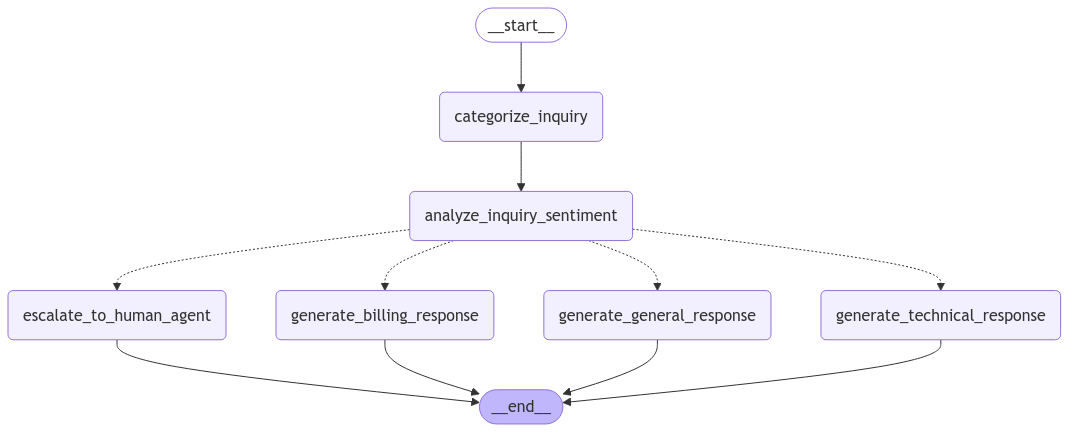

In [33]:
from IPython.display import display, Image, Markdown

display(Image(compiled_support_agent.get_graph().draw_mermaid_png()))

## Helper Function to Run the Workflow

This function takes a customer query and runs it through our compiled workflow, returning the final results (category, sentiment, and generated response).

In [34]:
def call_support_agent(agent, prompt, user_session_id, verbose=False):
    events = agent.stream(
        {"customer_query": prompt}, # initial state of the agent
        {"configurable": {"thread_id": user_session_id}},
        stream_mode="values",
    )

    print('Running Agent. Please wait...')
    for event in events:
        if verbose:
                print(event)

    display(Markdown(event['final_response']))

## Testing the Customer Support Workflow

Let's test the workflow with some sample queries to verify categorization, sentiment analysis, and response generation.

In [35]:
[item['text'] for item in knowledge_base]

['Question: How do I integrate your AI product with my existing CRM system? Answer: You can integrate our AI product with your CRM using our API. Refer to the API documentation available on our website for step-by-step guidance.',
 'Question: What programming languages are supported by your SDK? Answer: Our SDK supports Python, Java, and JavaScript. Additional language support is planned for future updates.',
 'Question: Can your AI models run on-premise? Answer: Yes, our AI models can be deployed on-premise. We provide deployment guides for various environments.',
 'Question: Does your hardware support edge AI applications? Answer: Yes, our hardware is optimized for edge AI, with low-latency processing and energy-efficient designs.',
 'Question: How do I troubleshoot issues with model performance? Answer: Start by reviewing the logs, checking resource utilization, and validating input data quality. You can also reach out to support for assistance.',
 'Question: Can I fine-tune your AI

In [36]:
uid = 'jim001'
query = "do you support pre-trained models?"
call_support_agent(agent=compiled_support_agent,
                   prompt=query,
                   user_session_id=uid,
                   verbose=True)

Running Agent. Please wait...
{'customer_query': 'do you support pre-trained models?'}
{'customer_query': 'do you support pre-trained models?', 'query_category': 'Technical'}
{'customer_query': 'do you support pre-trained models?', 'query_category': 'Technical', 'query_sentiment': 'Neutral'}
{'customer_query': 'do you support pre-trained models?', 'query_category': 'Technical', 'query_sentiment': 'Neutral', 'final_response': 'Yes, we do support pre-trained models. We offer a range of pre-trained models tailored for various use cases, including natural language processing (NLP), computer vision, and recommendation systems. Additionally, our platform allows you to fine-tune these models using your custom datasets to better suit your specific needs. If you require on-premise deployment, our AI models can be deployed in such environments, and we provide comprehensive deployment guides to assist you. If you have any further questions or need assistance, feel free to reach out.'}


Yes, we do support pre-trained models. We offer a range of pre-trained models tailored for various use cases, including natural language processing (NLP), computer vision, and recommendation systems. Additionally, our platform allows you to fine-tune these models using your custom datasets to better suit your specific needs. If you require on-premise deployment, our AI models can be deployed in such environments, and we provide comprehensive deployment guides to assist you. If you have any further questions or need assistance, feel free to reach out.

In [37]:
query = "how do I get my invoice?"
call_support_agent(agent=compiled_support_agent,
                   prompt=query,
                   user_session_id=uid,
                   verbose=True)

Running Agent. Please wait...
{'customer_query': 'how do I get my invoice?', 'query_category': 'Technical', 'query_sentiment': 'Neutral', 'final_response': 'Yes, we do support pre-trained models. We offer a range of pre-trained models tailored for various use cases, including natural language processing (NLP), computer vision, and recommendation systems. Additionally, our platform allows you to fine-tune these models using your custom datasets to better suit your specific needs. If you require on-premise deployment, our AI models can be deployed in such environments, and we provide comprehensive deployment guides to assist you. If you have any further questions or need assistance, feel free to reach out.'}
{'customer_query': 'how do I get my invoice?', 'query_category': 'Billing', 'query_sentiment': 'Neutral', 'final_response': 'Yes, we do support pre-trained models. We offer a range of pre-trained models tailored for various use cases, including natural language processing (NLP), comp

Thank you for reaching out with your query on obtaining your invoice. You can easily download a detailed invoice by accessing your account dashboard. Once logged in, navigate to the 'Billing' section where you will find the option to view and download your invoices. If you encounter any issues or need further assistance, please feel free to reach out.

In [38]:
query = "Can you tell me about your shipping policy?"
call_support_agent(agent=compiled_support_agent,
                   prompt=query,
                   user_session_id=uid,
                   verbose=False)

Running Agent. Please wait...


Thank you for reaching out with your query about our shipping policy. For hardware products, we offer free shipping on orders over $500. If your order is below $500, a flat shipping fee of $20 will be applied. Typically, shipping takes between 5-7 business days. If you have any further questions or need assistance, feel free to contact our support team.

In [39]:
query = "I'm fed up with this faulty hardware, I need a refund"
call_support_agent(agent=compiled_support_agent,
                   prompt=query,
                   user_session_id=uid,
                   verbose=True)

Running Agent. Please wait...
{'customer_query': "I'm fed up with this faulty hardware, I need a refund", 'query_category': 'General', 'query_sentiment': 'Neutral', 'final_response': 'Thank you for reaching out with your query about our shipping policy. For hardware products, we offer free shipping on orders over $500. If your order is below $500, a flat shipping fee of $20 will be applied. Typically, shipping takes between 5-7 business days. If you have any further questions or need assistance, feel free to contact our support team.'}
{'customer_query': "I'm fed up with this faulty hardware, I need a refund", 'query_category': 'Billing', 'query_sentiment': 'Neutral', 'final_response': 'Thank you for reaching out with your query about our shipping policy. For hardware products, we offer free shipping on orders over $500. If your order is below $500, a flat shipping fee of $20 will be applied. Typically, shipping takes between 5-7 business days. If you have any further questions or need

Apologies, we are really sorry! Someone from our team will be reaching out to your shortly!

In [41]:
query = "What are your working hours?"
call_support_agent(agent=compiled_support_agent,
                   prompt=query,
                   user_session_id=uid,
                   verbose=True)

Running Agent. Please wait...
{'customer_query': 'What are your working hours?', 'query_category': 'Billing', 'query_sentiment': 'Negative', 'final_response': 'Apologies, we are really sorry! Someone from our team will be reaching out to your shortly!'}
{'customer_query': 'What are your working hours?', 'query_category': 'General', 'query_sentiment': 'Negative', 'final_response': 'Apologies, we are really sorry! Someone from our team will be reaching out to your shortly!'}
{'customer_query': 'What are your working hours?', 'query_category': 'General', 'query_sentiment': 'Neutral', 'final_response': 'Apologies, we are really sorry! Someone from our team will be reaching out to your shortly!'}
{'customer_query': 'What are your working hours?', 'query_category': 'General', 'query_sentiment': 'Neutral', 'final_response': 'Thank you for reaching out with your query. Our support team is available to assist you from 9:00 AM to 6:00 PM, Monday to Friday. If you have any further questions or ne

Thank you for reaching out with your query. Our support team is available to assist you from 9:00 AM to 6:00 PM, Monday to Friday. If you have any further questions or need assistance outside of these hours, please feel free to contact us via email at support@example.com or call us at 1-800-123-4567. We are here to help!